# Sentiment Analysis with VADER and NLP Modeling
by: Caroline Schmitt and Heather Robbins

https://github.com/cjhutto/vaderSentiment

In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

## Load in the text data:

In [255]:
tweets = pd.read_csv('trump_clinton_tweets.csv')
tweets.head(3)

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,"{'media': [{'display_url': 'pic.twitter.com/XreEY9OicG', 'expanded_url': 'https://twitter.com/HillaryClinton/status/780925634159796224/video/1', 'sizes': {'medium': {'h': 675, 'resize': 'fit', 'w'...","{'media': [{'display_url': 'pic.twitter.com/XreEY9OicG', 'sizes': {'medium': {'h': 675, 'resize': 'fit', 'w': 1200}, 'small': {'h': 383, 'resize': 'fit', 'w': 680}, 'large': {'h': 720, 'resize': '..."
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I call it? Unpatriotic. https://t.co/t0xmBfj7zF",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,"{'media': [{'display_url': 'pic.twitter.com/t0xmBfj7zF', 'sizes': {'medium': {'h': 512, 'resize': 'fit', 'w': 1024}, 'thumb': {'h': 150, 'resize': 'crop', 'w': 150}, 'large': {'h': 512, 'resize': ...","{'media': [{'display_url': 'pic.twitter.com/t0xmBfj7zF', 'sizes': {'medium': {'h': 512, 'resize': 'fit', 'w': 1024}, 'thumb': {'h': 150, 'resize': 'crop', 'w': 150}, 'large': {'h': 512, 'resize': ..."
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during last night's debate showed that she's ready to be our next @POTUS.,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'name': 'President Obama', 'id': 1536791610, 'screen_name': 'POTUS', 'indices': [3, 9]}, {'id_str': '1339835893', 'name': 'Hillary Clinton', 'id': 13398...",NaN


In [256]:
# remove retweets
tweets = tweets[tweets['is_retweet'] == False]

In [257]:
tweets = tweets[['handle', 'text']].copy()

## Format tweets for VADER:

The `SentimentIntensityAnalyzer` will expect a list of strings.

In [258]:
#convert to a list of strings:

corpus = list(tweets['text'])
corpus[0]

'The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG'

## Instantiate `SentimentIntensityAnalyzer` and test it on the first tweet:

In [259]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'compound': 0.4404}

## Dataframe of sentiment analyses:

In [260]:
tweets.head(5)

,handle,text
0,HillaryClinton,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG
3,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy"
4,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis
5,realDonaldTrump,"Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc"
6,HillaryClinton,This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H


In [261]:
#create dataframe that contains text and the polarity scores for each tweet

dicts = []    

for tweet in corpus:
    scores = sia.polarity_scores(tweet)
    scores['text'] = tweet
    dicts.append(scores)

df = pd.DataFrame(dicts)
df.head()

,compound,neg,neu,pos,text
0,0.4404,0.000,0.861,0.139,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG
1,0.1376,0.101,0.771,0.128,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy"
2,-0.6597,0.278,0.722,0.000,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis
3,0.3595,0.000,0.858,0.142,"Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc"
4,0.4767,0.000,0.796,0.204,This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H


## Add original author:

In [262]:
df['author'] = tweets['handle'].values
df.head(5)

,compound,neg,neu,pos,text,author
0,0.4404,0.000,0.861,0.139,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG,HillaryClinton
1,0.1376,0.101,0.771,0.128,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy",HillaryClinton
2,-0.6597,0.278,0.722,0.000,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis,HillaryClinton
3,0.3595,0.000,0.858,0.142,"Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc",realDonaldTrump
4,0.4767,0.000,0.796,0.204,This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H,HillaryClinton


## Investigating polarities:

In [263]:
df.sort_values(by='neg', ascending=False).head(20)

,compound,neg,neu,pos,text,author
3355,-0.5267,0.773,0.227,0.000,Disgusting. https://t.co/A8Hm24ZT1H,HillaryClinton
1528,-0.8697,0.621,0.379,0.000,"Even Bill is tired of the lies, SAD! https://t.co/LPk1OkwH9P",realDonaldTrump
3988,-0.6943,0.589,0.411,0.000,Hate isn't an American value. https://t.co/lZJ8T0Xu3M,HillaryClinton
2923,-0.9325,0.583,0.417,0.000,Your @GOP presidential nominee responding to a terrorist attack with lies and conspiracy theories.\nhttps://t.co/TZJmXefmx4,HillaryClinton
2877,-0.9509,0.565,0.435,0.000,"Gun violence and hate aren't isolated—homophobia in Orlando, racism in Charleston. We need to fight them together. https://t.co/HcBJzknBz7",HillaryClinton
4541,-0.9360,0.560,0.440,0.000,"""@Ma1973sk: Actually, no @FoxNews, @megynkelly has a sick obsession with Trump. Every day, every show, trashing, negative, hate.",realDonaldTrump
2583,-0.9584,0.548,0.452,0.000,"Yet another terrorist attack today in Israel -- a father, shot at by a Palestinian terrorist, was killed while:\nhttps://t.co/Cv1HzKVbiT",realDonaldTrump
1321,-0.7645,0.546,0.287,0.167,"Donald Trump's no good, horrible, very bad week. https://t.co/MtgwywgJ3q",HillaryClinton
2659,-0.9349,0.542,0.458,0.000,"""Hillary believes that racism, hatred, injustice, and bigotry have no place in our country."" —@ElizabethforMA\nhttps://t.co/OK5UueAaZn",HillaryClinton
3009,-0.9286,0.536,0.464,0.000,Really bad shooting in Orlando. Police investigating possible terrorism. Many people dead and wounded.,realDonaldTrump


# Visualizing sentiments

Let's do some EDA on the sentiments.

### Plot the average positivity and negativity for each politician:

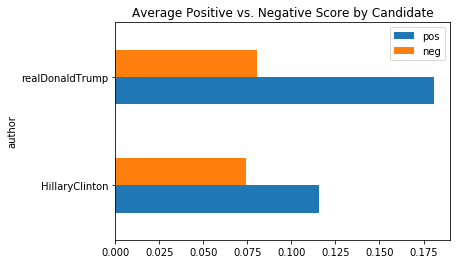

In [264]:
df.groupby('author').mean()[['pos', 'neg']].plot(kind='barh')
plt.title('Average Positive vs. Negative Score by Candidate');

### Plot a boxplot of compound scores for each politician:

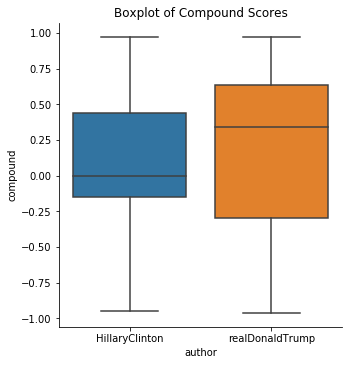

In [265]:
sns.catplot(x='author', y='compound', kind='box', data=df)
plt.title('Boxplot of Compound Scores');

### Plot a boxplot of positive scores for each politician:

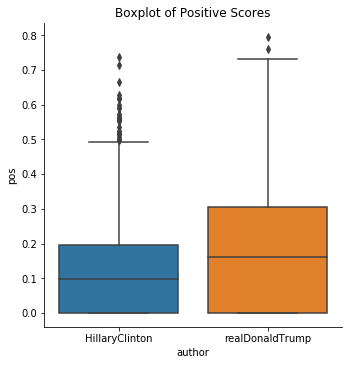

In [266]:
sns.catplot(x='author', y='pos', kind='box', data=df)
plt.title('Boxplot of Positive Scores');

### Plot a boxplot of neutral scores for each politician:

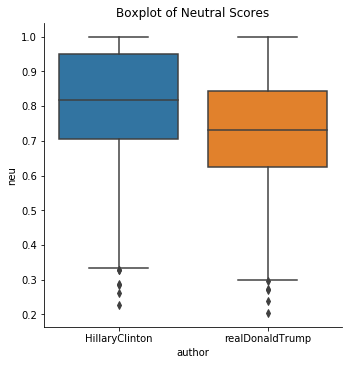

In [267]:
sns.catplot(x='author', y='neu', kind='box', data=df)
plt.title('Boxplot of Neutral Scores');

# Modeling-Prep

In [268]:
df.head()

,compound,neg,neu,pos,text,author
0,0.4404,0.000,0.861,0.139,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG,HillaryClinton
1,0.1376,0.101,0.771,0.128,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy",HillaryClinton
2,-0.6597,0.278,0.722,0.000,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis,HillaryClinton
3,0.3595,0.000,0.858,0.142,"Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc",realDonaldTrump
4,0.4767,0.000,0.796,0.204,This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H,HillaryClinton


In [269]:
df['is_trump'] = df['author'].map(lambda x: 1 if x == 'realDonaldTrump' else 0)

In [270]:
df.head()

,compound,neg,neu,pos,text,author,is_trump
0,0.4404,0.000,0.861,0.139,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG,HillaryClinton,0
1,0.1376,0.101,0.771,0.128,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy",HillaryClinton,0
2,-0.6597,0.278,0.722,0.000,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis,HillaryClinton,0
3,0.3595,0.000,0.858,0.142,"Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc",realDonaldTrump,1
4,0.4767,0.000,0.796,0.204,This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H,HillaryClinton,0


In [271]:
#split text data intro training and test sets

X = df[['text', 'compound', 'neg', 'neu', 'pos']]
y = df['is_trump']

In [272]:
X.shape

(5722, 5)

In [273]:
#check for balanced classes 

y.value_counts()

1    3093
0    2629
Name: is_trump, dtype: int64

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [275]:
# get baseline accuracy for training & test set

y_train.mean(), y_test.mean()

(0.539654795717719, 0.5441048034934498)

### CountVectorizer

In [276]:
cv = CountVectorizer(stop_words = 'english', max_features=2000, ngram_range = (2,5), min_df=3)

cv.fit(X_train['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=3,
        ngram_range=(2, 5), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [277]:
#transform training and test text
X_train_cv = cv.transform(X_train['text'])
X_test_cv = cv.transform(X_test['text'])

In [278]:
#create new dataframes for training and test text

df_X_train = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [279]:
df_X_test = pd.DataFrame(X_test_cv.todense(), columns = cv.get_feature_names())

In [280]:
##reset indices in all dataframes

In [281]:
df_X_train.reset_index(drop=True, inplace=True)

In [282]:
X_train.reset_index(drop=True, inplace=True)

In [283]:
df_X_test.reset_index(drop=True, inplace = True)

In [284]:
X_test.reset_index(drop=True, inplace=True)

In [285]:
### add sentiment scores back to text data. merge on index
combined_X_train = pd.concat([df_X_train, X_train], axis =1)
combined_X_train.head(1)

,00 enjoy,000 000,000 amazing,000 amazing supporters,000 https,000 jobs,000 people,000 year,000 year ll,10 00,...,years ago today,years obama,york love,york times,young people,text,compound,neg,neu,pos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"Great even in SC tonight! Fire Marshall would not let everyone in-- 5,000 turned away. Thank you for coming!",0.6988,0.094,0.625,0.281


In [286]:
combined_X_test = pd.concat([df_X_test, X_test], axis = 1)

In [287]:
combined_X_train.drop(columns = 'text', inplace=True)

In [288]:
combined_X_test.drop(columns = 'text', inplace = True)

In [289]:
##checking all my data dimensions

In [290]:
combined_X_train.shape

(4577, 1909)

In [291]:
y_train.shape

(4577,)

In [292]:
combined_X_test.shape

(1145, 1909)

In [293]:
y_test.shape

(1145,)

### Modeling Time!

In [294]:
#instantiate LogisticRegression

In [295]:
lr = LogisticRegression()
lr.fit(combined_X_train, y_train)

/Users/heatherrobbins/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [296]:
lr.score(combined_X_train, y_train), lr.score(combined_X_test, y_test)

(0.874590343019445, 0.7938864628820961)

In [297]:
#instantiate RandomForestClassifier

In [298]:
rfc = RandomForestClassifier()

In [299]:
rfc.fit(combined_X_train, y_train)

/Users/heatherrobbins/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [300]:
rfc.score(combined_X_train, y_train), rfc.score(combined_X_test, y_test)

(0.9639501857111645, 0.7502183406113537)

In [ ]:
##this model is clearly overfit - so I'd need to go back and play around with some hyperparameters to make it better.

In [301]:
#determine most important features
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = combined_X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
rfc_feature_importances.head(20)



,importance
compound,0.102964
neu,0.094360
pos,0.074893
neg,0.047772
donald trump,0.029361
trump2016 https,0.019085
crooked hillary,0.013356
hillary https,0.011053
makeamericagreatagain https,0.008655
ted cruz,0.008308
